# Sentence Classification

## This notebook walks through the steps in creating a sentence classifier 

### 1. Data preparation
### 2. Feature generation
### 3. Model building
### 4. Training
### 5. Results

# First we get some important libraries

In [1]:
### First we import the needed libraries
import os
import sys
import pandas as pd
import numpy as np
import json
import pickle

import re

from sklearn import metrics
np.random.seed(123)


## The following are the neural network libraries

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Merge, Reshape, Concatenate, BatchNormalization
from keras.layers import Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, Embedding, LSTM, Dropout, BatchNormalization
from keras.models import Model, Sequential

Using TensorFlow backend.


## 1. Data preparation
### We load the raw data

In [3]:
sentences = pd.read_json("../coded_sentences.json",orient='values')
sentences = sentences.drop_duplicates(subset=1, inplace=False)

### Here is what it looks like

In [4]:
sentences.head(3)

,0,1,2,3,4
0,200200342348,Pakistan TV Show: PTI Leader Says MQM Assured ...,0,0,171
1,200200342348,Karachi Geo News television in Urdu at 1505 GM...,0,179,316
2,200200342348,Prominent Pakistani journalist Talat Hussain i...,0,317,385


### Columns 1 and 2 are the most important. Column 2 is the label, either 0 or 1, for a positive or negative example

## Next we clean up the data by removing samples with errors

In [5]:
#to remove fused sentences
pattern_delete = "\|\d*\|"
pd_filter = sentences[1].str.contains(pattern_delete)
sentences = sentences[~pd_filter]

#add space around punctuation so it can be added to the word dictionary
sentences[1] = sentences[1].map(lambda x: re.sub('(["\'.:!?()])', r' \1 ', x))

#reset the index since our removal above has chopped out some middle samples
sentences = sentences.reset_index(drop=True)
#remove blank sentences
sentences = sentences.drop(sentences.index[[93536,395266]])
sentences = sentences.reset_index(drop=True)


## 2. Feature Generation - After cleaning we are ready to make the word dictionary

In [6]:
MAX_SEQUENCE_LENGTH = 200
MAX_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

#create the word index dictionary
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(sentences.iloc[:,1])
sequences = tokenizer.texts_to_sequences(sentences.iloc[:,1])
    
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

#convert data to word indexes
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(sentences.iloc[:,2])

Found 66901 unique tokens.


## Now the words have been converted to numbers so we can feed them into the network

In [13]:
str(sequences[0])

'[15, 303, 560, 63, 140, 90, 175, 1085, 80, 1335, 2, 6361, 40, 488, 303, 55, 2383, 172, 52, 945, 221, 185, 236, 5280, 137, 15]'

## Randomly shuffling the data is good practice

In [7]:
#shuffling data for training
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]


### We have a good number of training examples, 400,000, so we break them up into a 60/10/30 split for training, validating, and testing

In [8]:
x_train = data[:350000]
y_train = labels[:350000]

x_val = data[350000:370000]
y_val = labels[350000:370000]

x_test = data[370000:]
y_test = labels[370000:]


## 3. Model Building - It's time to make the neural network model
### First we load up some weights from a pretrained network

In [9]:
#loading the pretrained embeddings
embeddings_index = {}

f = open("../glove.6B.100d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Next we set up the model architecture

In [10]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))

model.add(Conv1D(50, kernel_size=20, padding='same', activation='relu'))
model.add(Conv1D(50, kernel_size=5, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])



## 4. Training - And then we train
### About 4 runs is sufficient

In [13]:
#training
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=1, batch_size=128)

Train on 350000 samples, validate on 20000 samples
Epoch 1/1
350000/350000 [==============================] - 1400s 4ms/step - loss: 0.4249 - acc: 0.8216 - val_loss: 0.4457 - val_acc: 0.8136


### And save

In [14]:
model.save("sentence_predictor")

# 5. Results
### We load some graphing libraries

In [15]:
### Plotting after training the model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support


## We query the model to see what it guesses for data it has never seen - the test set

In [18]:
#get the predictions from the model
y_pred = model.predict(x_test, batch_size=64)

#switch the multi output neurons back to a number label
y_pred = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

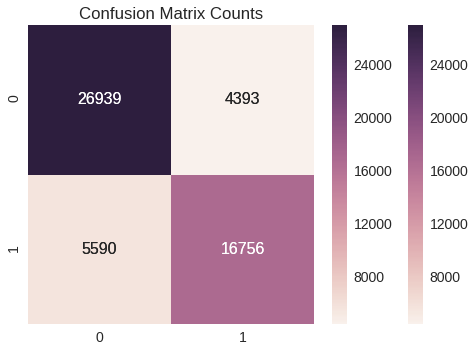

In [20]:
#create a confusion matrix
c_matrix = metrics.confusion_matrix(y_test_labels, y_pred)

df_cm = pd.DataFrame(c_matrix, range(2),
                  range(2))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')# font size
plt.title("Confusion Matrix Counts")
plt.show()


## Above are the raw counts, now we can calculate the f-score, precision, and recall

In [38]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_labels, y_pred, average='weighted')
print("precision {0}, recall {1}, fscore {2}".format(round(precision,3), round(recall,3), round(fscore,3)))

precision 0.813, recall 0.814, fscore 0.813
